# Final analysis

This notebook contains the final form of our analysis as well as the final form of the data cleaning process.

In [1]:
from utils import *

In [2]:
path = r'/home/daniel/code/costofcare/data/bhp_ukhls_data_stata/UKDA-6614-stata/stata/ukhls'
my_colnames = [
                'hidp',
                'sex',
                'jbnssec_dv',
                'jbnssec8_dv',
                'jbstat',
                'jbhrs',
                'ethn_dv',
                'dvage',
                'mastat_dv',
                'country',
                'aidhh',
                'aidhrs',
                'aidxhh',
                'paygu_dv',
                'qfhigh',
                'qfhigh_dv',
                'istrtdatm',
                'istrtdaty',
                'month'
]

In [3]:
data = load_data(path, my_colnames)

In [4]:
cpih = pd.read_csv('./cpih_uk_88_23.csv')
data_clean = recoding_and_cleaning(data, cpih)

/home/daniel/code/costofcare/utils.py:170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['jbhrs_clean'][data.jbhrs_clean < 1] = np.nan


In [5]:
pd.crosstab(data_clean.istrtdaty, data_clean.year)

year,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0
istrtdaty,,,,,,,,,,,,,
2009,24380,1,0,0,0,0,0,0,0,0,0,0,0
2010,1327,53651,1,0,0,0,0,0,0,0,0,0,0
2011,0,4083,48828,0,0,0,0,0,0,0,0,0,0
2012,0,0,2687,44946,0,0,0,0,0,0,0,0,0
2013,0,0,0,3061,41952,0,0,0,0,0,0,0,0
2014,0,0,0,12,3909,39299,3,0,0,0,0,0,0
2015,0,0,0,0,4,3300,36161,0,0,0,0,0,0
2016,0,0,0,0,0,0,3366,37238,166,0,0,0,0
2017,0,0,0,0,0,0,0,3559,33853,0,0,0,0


In [6]:
import operator

conds = {
    'employed': True,
    'dropna': True,
    'target_var': 'wage_h_deflated',
    'treat_var': 'aidhrs_recoded_3',
    'treat_value': '0-19',
    'treat_rule_main': operator.eq,
    'treat_rule_op': operator.or_,
    'control_var': 'aidhrs',
    'control_value': 'inapplicable',
    'control_rule': operator.eq,
    'min_treat_waves': 3
}

In [7]:
def isc_data_preparation(data, conditions: dict):
    out = data.copy()
    employed = conditions['employed']
    dropna = conditions['dropna']
    target_var = conditions['target_var']
    min_treat_waves = conditions['min_treat_waves']
    if employed: # dropping if ever unemployed
        out['unemployed_bool'] = ~(out.employed == 'employed')
        out_copy = out.copy()
        to_drop = []
        for pidp in out.pidp.unique():
            temp_data = out[out.pidp==pidp].copy()
            if temp_data['unemployed_bool'].any(): #check if any time was unemployed
                to_drop.append(pidp) # adds to drop if above is true
        out = out_copy[~out_copy.pidp.isin(to_drop)].copy()
    if dropna: #dropping if ever missing in target var
        out_copy = out.copy()
        to_drop = []
        for pidp in out.pidp.unique():
            temp_data = out[out.pidp==pidp].copy()
            if temp_data[target_var].isnull().any():
                to_drop.append(pidp)
        out = out_copy[~out_copy.pidp.isin(to_drop)].copy()
    treat_rule_main = conditions['treat_rule_main']
    treat_rule_op = conditions['treat_rule_op']
    treat_var = conditions['treat_var']
    treat_value = conditions['treat_value']
    control_var = conditions['control_var']
    control_value = conditions['control_value']
    control_rule = conditions['control_rule']
    out['control'] = (control_rule(out[control_var], control_value))
    if isinstance(treat_value, list): #multiple conditions divergence
        out['treated'] = treat_rule_op(treat_rule_main(out[treat_var], treat_value[0]),
                        treat_rule_main(out[treat_var], treat_value[1]))
        out['ever_treated'] = out.groupby('pidp')['treated'].transform(any)
        out['wave_reindex'] = out.sort_values(by=['pidp', 'wave']).groupby('pidp').cumcount() + 1
        out.reset_index(drop=True, inplace=True)
        out.sort_values(by=['pidp', 'wave_reindex'], inplace=True)
        out['wave_treated'] = out.wave[out.groupby('pidp')['treated'].transform('idxmax').values].values
        out['wave_treat_reindex'] = out.wave_reindex[out.groupby('pidp')['treated'].transform('idxmax').values].values
        out['initial_wave'] = out.groupby('pidp')['wave'].transform('min').values
        out['reindex'] = out.groupby('pidp')['wave_treat_reindex'].transform(create_index)
        out['waves_treated'] = out.groupby('pidp')['treated'].transform('sum')
    else:
        out['treated'] = (treat_rule_main(out[treat_var], treat_value))
        out['over_treated'] = (out.aidhrs_recoded_3=='20-49') | (out.aidhrs_recoded_3=='50+')
        out['over_treated_any'] = out.groupby('pidp')['over_treated'].transform(any).values
        out = out[~out.over_treated_any].copy()
        out['ever_treated'] = out.groupby('pidp')['treated'].transform(any).values
        out['year_reindex'] = out.sort_values(by=['pidp', 'year']).groupby('pidp').cumcount() + 1
        out.reset_index(drop=True, inplace=True)
        out.sort_values(by=['pidp', 'year_reindex'], inplace=True)
        out['year_treated'] = out.year[out.groupby('pidp')['treated'].transform('idxmax').values].values
        out['year_treat_reindex'] = out.year_reindex[out.groupby('pidp')['treated'].transform('idxmax').values].values
        out['initial_year'] = out.groupby('pidp')['year'].transform('min').values
        out['reindex'] = out.groupby('pidp')['year_treat_reindex'].transform(create_index).values
        out['years_treated'] = out.groupby('pidp')['treated'].transform('sum').values
    treated = out[out.ever_treated].copy()
    control = out[out.control].copy()
    to_drop = []
    for pidp in control.pidp.unique():
        if pidp in treated.pidp.unique():
            to_drop.append(pidp)
    control = control[~control.pidp.isin(to_drop)].copy()
    control['ever_treated'] = control.groupby('pidp')['treated'].transform(any)
    treated = treated[~(treated.years_treated < min_treat_waves)].copy()
    treated = treated.drop(treated[(treated.year_treat_reindex < 4)].index).copy()
    return treated, control

In [8]:
treated, control = isc_data_preparation(data_clean, conds)

In [9]:
treated.to_csv('treated.csv')
control.to_csv('control.csv')

In [10]:
treated[treated.pidp==68068011].year - treated[treated.pidp==68068011].year_treated

22      -7.0
12358   -6.0
24282   -5.0
34275   -4.0
43200   -3.0
51436   -2.0
59831   -1.0
67448    0.0
74513    1.0
80932    2.0
87081    3.0
92963    4.0
dtype: float64

In [52]:
treated[treated.pidp==68068011]

,pidp,hidp,sex,jbnssec_dv,jbnssec8_dv,jbstat,jbhrs,ethn_dv,dvage,mastat_dv,...,treated,over_treated,over_treated_any,ever_treated,year_reindex,year_treated,year_treat_reindex,initial_year,reindex,years_treated
22,68068011,68068003,female,4.1 Lower prof./higher techn.: 'traditional' e...,Lower management & professional,Paid employment(ft/pt),37.0,british/english/scottish/welsh/northern irish,42,Married,...,False,False,False,True,1,2016.0,8,2009.0,-7,5
12358,68068011,68414802,female,4.1 Lower prof./higher techn.: 'traditional' e...,Lower management & professional,Paid employment(ft/pt),37.0,british/english/scottish/welsh/northern irish,43,Married,...,False,False,False,True,2,2016.0,8,2009.0,-6,5
24282,68068011,68462404,female,4.1 Lower prof./higher techn.: 'traditional' e...,Lower management & professional,Paid employment(ft/pt),37.0,british/english/scottish/welsh/northern irish,44,Married,...,False,False,False,True,3,2016.0,8,2009.0,-5,5
34275,68068011,68421606,female,4.1 Lower prof./higher techn.: 'traditional' e...,Lower management & professional,Paid employment(ft/pt),37.0,british/english/scottish/welsh/northern irish,45,Married,...,False,False,False,True,4,2016.0,8,2009.0,-4,5
43200,68068011,68360408,female,4.1 Lower prof./higher techn.: 'traditional' e...,Lower management & professional,Paid employment(ft/pt),37.0,british/english/scottish/welsh/northern irish,46,Married,...,False,False,False,True,5,2016.0,8,2009.0,-3,5
51436,68068011,68340010,female,4.1 Lower prof./higher techn.: 'traditional' e...,Lower management & professional,Paid employment(ft/pt),38.0,british/english/scottish/welsh/northern irish,47,Married,...,False,False,False,True,6,2016.0,8,2009.0,-2,5
59831,68068011,68340012,female,4.1 Lower prof./higher techn.: 'traditional' e...,Lower management & professional,Paid employment(ft/pt),37.0,british/english/scottish/welsh/northern irish,48,Married,...,False,False,False,True,7,2016.0,8,2009.0,-1,5
67448,68068011,68326414,female,4.1 Lower prof./higher techn.: 'traditional' e...,Lower management & professional,Paid employment(ft/pt),37.5,british/english/scottish/welsh/northern irish,49,Married,...,True,False,False,True,8,2016.0,8,2009.0,0,5
74513,68068011,68326416,female,4.1 Lower prof./higher techn.: 'traditional' e...,Lower management & professional,Paid employment(ft/pt),37.5,british/english/scottish/welsh/northern irish,50,Married,...,True,False,False,True,9,2016.0,8,2009.0,1,5
80932,68068011,68312818,female,4.1 Lower prof./higher techn.: 'traditional' e...,Lower management & professional,Paid employment(ft/pt),30.0,british/english/scottish/welsh/northern irish,51,Married,...,True,False,False,True,10,2016.0,8,2009.0,2,5


In [51]:
treated[treated.pidp==1651971690]

,pidp,hidp,sex,jbnssec_dv,jbnssec8_dv,jbstat,jbhrs,ethn_dv,dvage,mastat_dv,...,treated,over_treated,over_treated_any,ever_treated,year_reindex,year_treated,year_treat_reindex,initial_year,reindex,years_treated


# Treatment Variable

## Decision
Recoding treatment variable

## Note
The variable below identifies the people who provided care under our specific conditions based on the 3 variables above.

In [180]:
#data['carer'] = ((data.aidhh_recoded == 'yes') | (data.aidxhh_recoded == 'yes') | (~data.aidhrs_recoded_3.isnull()))

Counting how many waves are carers taking care responsabilities on average

## Decision
We will use a "generalised" moment of treatment with at least 3 measures before, and at least 1 after.

# Target Variable

Number of employed individuals in the sample

## Decision
We are considering only employed individuals

# ISC Data preparation

In [202]:
isc_data = df_6_emp[['pidp', 'carer', 'wage_deflated',
                     'log_wage_h_deflated', 'wage_h_deflated',
                     'wave', 'date', 'employed', 'dvage', 
                     'ever_carer', 'carer_second',
                    'aidhrs', 'ever_carer_second']]

### Average number of waves caring

## Decision
We will take the average as lower limit to determine treated cases. Everyone with less than 3 and more than 1 reported waves of caring will be dropped.

In [212]:
isc_data['waves_treated'] = isc_data.groupby('pidp')['carer_second'].transform('sum')
isc_data[isc_data.pidp==68004087] # this guys should go in the next step

,pidp,carer,wage_deflated,log_wage_h_deflated,wage_h_deflated,wave,date,employed,dvage,ever_carer,carer_second,aidhrs,wave_reindex,wave_treat,wave_treat_real,initial_wave,reindex,waves_caring
0,68004087,False,1241.339492,1.994817,7.350859,1,2009-01-01,employed,59,False,False,inapplicable,1,1,1,1,0,0
8843,68004087,False,1348.314607,2.077481,7.984335,2,2010-02-01,employed,60,False,False,inapplicable,2,1,1,1,1,0
20453,68004087,True,1352.112676,2.080294,8.006826,3,2011-02-01,employed,61,False,False,0 - 4 hours per week,3,1,1,1,2,0
32054,68004087,False,1247.096093,1.999444,7.384948,4,2012-01-01,employed,62,False,False,inapplicable,4,1,1,1,3,0
43708,68004087,False,1149.484536,1.917940,6.806920,5,2013-01-01,employed,63,False,False,inapplicable,5,1,1,1,4,0
55454,68004087,False,1264.853978,2.013583,7.490105,6,2014-03-01,employed,64,False,False,inapplicable,6,1,1,1,5,0
67386,68004087,False,1201.201201,1.961948,7.113171,7,2015-04-01,employed,65,False,False,inapplicable,7,1,1,1,6,0
79009,68004087,False,1281.418694,2.026594,7.588196,8,2016-05-01,employed,66,False,False,inapplicable,8,1,1,1,7,0
90084,68004087,False,1131.207400,2.010125,7.464252,9,2017-03-01,employed,67,False,False,inapplicable,9,1,1,1,8,0


In [214]:
isc_data = isc_data[~((isc_data.waves_caring >= 1) & (isc_data.waves_caring < 3))]

In [216]:
isc_data.sort_values(by=['wave', 'pidp']) # but we still have people with 0 waves of caring for the control pool

,pidp,carer,wage_deflated,log_wage_h_deflated,wage_h_deflated,wave,date,employed,dvage,ever_carer,carer_second,aidhrs,wave_reindex,wave_treat,wave_treat_real,initial_wave,reindex,waves_caring
0,68004087,False,1241.339492,1.994817,7.350859,1,2009-01-01,employed,59,False,False,inapplicable,1,1,1,1,0,0
1,68009527,False,4753.660418,3.390185,29.671434,1,2009-01-01,employed,31,False,False,inapplicable,1,1,1,1,0,0
2,68011567,False,3050.173154,2.946468,19.038594,1,2009-01-01,employed,35,False,False,inapplicable,1,1,1,1,0,0
3,68028571,False,2501.928316,2.748332,15.616555,1,2009-01-01,employed,42,True,False,inapplicable,1,1,1,1,0,0
4,68029927,False,303.130719,1.763690,5.833925,1,2009-02-01,employed,36,False,False,inapplicable,1,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127455,1651754090,False,4528.194498,3.263632,26.144310,12,2021-11-01,employed,50,False,False,inapplicable,7,1,6,6,6,0
127457,1652121250,False,4749.332740,3.375851,29.249162,12,2021-09-01,employed,42,False,False,inapplicable,7,1,6,6,6,0
127458,1652311810,False,2248.677249,2.786794,16.228906,12,2021-10-01,employed,31,False,False,inapplicable,7,1,6,6,6,0
127459,1652814850,False,6134.969325,3.567313,35.421301,12,2021-11-01,employed,58,True,True,35 - 49 hours per week,7,5,10,6,2,3


## Decision
Only carers with at least 3 data points before treatment are consider.

In [218]:
isc_data = isc_data.drop(isc_data[(isc_data.wave_treat < 4) & (isc_data.ever_carer == True)].index)

In [219]:
isc_data[isc_data.pidp==1651971690] #this guys should not be here an is not, so we are good

,pidp,carer,wage_deflated,log_wage_h_deflated,wage_h_deflated,wave,date,employed,dvage,ever_carer,carer_second,aidhrs,wave_reindex,wave_treat,wave_treat_real,initial_wave,reindex,waves_caring


In [220]:
isc_data

,pidp,carer,wage_deflated,log_wage_h_deflated,wage_h_deflated,wave,date,employed,dvage,ever_carer,carer_second,aidhrs,wave_reindex,wave_treat,wave_treat_real,initial_wave,reindex,waves_caring
32050,22445,False,1251.303441,2.488320,12.041026,4,2012-04-01,employed,27,False,False,inapplicable,1,1,4,4,0,0
43703,22445,False,1595.162883,2.325645,10.233275,5,2013-05-01,employed,28,False,False,inapplicable,2,1,4,4,1,0
55449,22445,False,2487.565218,2.798144,16.414155,6,2014-06-01,employed,29,False,False,inapplicable,3,1,4,4,2,0
67379,22445,False,2813.856066,2.787864,16.246282,7,2015-06-01,employed,30,False,False,inapplicable,4,1,4,4,3,0
79002,22445,False,2874.132805,2.887021,17.939784,8,2016-07-01,employed,31,False,False,inapplicable,5,1,4,4,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127460,1652835250,False,1423.970202,2.184719,8.888148,12,2021-11-01,employed,50,False,False,inapplicable,6,1,6,6,5,0
67377,1652984890,False,3154.053707,3.499834,33.109949,6,2015-12-01,employed,65,False,False,Not available for IEMB,1,1,6,6,0,0
79000,1652984890,False,3110.677723,2.939442,18.905298,7,2017-01-01,employed,66,False,False,inapplicable,2,1,6,6,1,0
67378,1653059650,False,2796.853049,2.781803,16.148112,6,2016-02-01,employed,59,False,False,Not available for IEMB,1,1,6,6,0,0


In [221]:
#isc_data = isc_data.dropna()

In [222]:
isc_data.to_csv('isc_data.csv')

In [214]:
carers = isc_data[isc_data.ever_carer]

NameError: name 'isc_data' is not defined

In [215]:
controls = isc_data[~isc_data.ever_carer]

NameError: name 'isc_data' is not defined

In [213]:
len(carers.pidp.unique())

NameError: name 'carers' is not defined

In [123]:
carers

,pidp,carer,wage_deflated,wage_h_deflated,wave,date,employed,dvage,waves_caring,wave_reindex,wave_treat,wave_treat_real,initial_wave,reindex,ever_carer
17,68068011,False,3142.124802,19.612539,1,2009-01-01,employed,42,5,1,8,8,1,-7,True
6827,68068011,False,3137.759097,19.585289,2,2010-01-01,employed,43,5,2,8,8,1,-6,True
15807,68068011,False,3103.573070,19.371906,3,2011-01-01,employed,44,5,3,8,8,1,-5,True
24812,68068011,False,3035.902851,18.949522,4,2012-01-01,employed,45,5,4,8,8,1,-4,True
33882,68068011,False,2937.195957,18.333412,5,2013-01-01,employed,46,5,5,8,8,1,-3,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70214,1633102291,False,1722.488038,18.943012,8,2018-01-01,employed,37,3,8,10,10,1,-2,True
78418,1633102291,False,1638.576779,18.020200,9,2019-02-01,employed,38,3,9,10,10,1,-1,True
86158,1633102291,True,1569.713758,17.262881,10,2020-01-01,employed,39,3,10,10,10,1,0,True
93385,1633102291,True,1715.462031,18.865743,11,2021-01-01,employed,40,3,11,10,10,1,1,True


In [124]:
def get_control_clean(c_data, t_data):
    samples = []
    t_ids = t_data.pidp.unique().tolist()
    for t_id in t_ids:
        out = {}
        init = t_data[t_data.pidp == t_id].initial_wave.unique()[0]
        treat_time = t_data[t_data.pidp == t_id].wave_treat_real.unique()[0]
        last_wave = t_data[t_data.pidp == t_id].wave.max()
        length = (last_wave + 1) - init
        # HUGE PROBLEM HERE waves need to match exactly!!! do not use range!!!
        idx = c_data[(c_data.wave >= init) & (c_data.wave <= last_wave)].groupby('pidp')['pidp'].transform('count') == length
        sub_sample = c_data[(c_data.wave >= init) & (controls.wave <= last_wave)][idx].reset_index(drop=True)
        treat = t_data[t_data.pidp == t_id].pivot(index='wave', columns='pidp', values='wage_h_deflated')
        #treat.columns = ['treated']
        sub_sample = sub_sample.pivot(index='wave', columns='pidp', values='wage_h_deflated')
        sub_sample = pd.concat([treat, sub_sample], axis=1, join="inner")
        out['data'] = sub_sample
        out['treat_time'] = treat_time
        samples.append(out)
    return samples

In [125]:
def is_consecutive(l):
    return sorted(l) == list(range(min(l), max(l)+1))
idx = []
for pidp in carers.pidp:
    idx.append(is_consecutive(carers[carers.pidp == pidp].wave))

In [126]:
len(carers[idx].pidp.unique())

414

In [127]:
samples = get_control_clean(controls, carers[idx])

In [128]:
carers

,pidp,carer,wage_deflated,wage_h_deflated,wave,date,employed,dvage,waves_caring,wave_reindex,wave_treat,wave_treat_real,initial_wave,reindex,ever_carer
17,68068011,False,3142.124802,19.612539,1,2009-01-01,employed,42,5,1,8,8,1,-7,True
6827,68068011,False,3137.759097,19.585289,2,2010-01-01,employed,43,5,2,8,8,1,-6,True
15807,68068011,False,3103.573070,19.371906,3,2011-01-01,employed,44,5,3,8,8,1,-5,True
24812,68068011,False,3035.902851,18.949522,4,2012-01-01,employed,45,5,4,8,8,1,-4,True
33882,68068011,False,2937.195957,18.333412,5,2013-01-01,employed,46,5,5,8,8,1,-3,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70214,1633102291,False,1722.488038,18.943012,8,2018-01-01,employed,37,3,8,10,10,1,-2,True
78418,1633102291,False,1638.576779,18.020200,9,2019-02-01,employed,38,3,9,10,10,1,-1,True
86158,1633102291,True,1569.713758,17.262881,10,2020-01-01,employed,39,3,10,10,10,1,0,True
93385,1633102291,True,1715.462031,18.865743,11,2021-01-01,employed,40,3,11,10,10,1,1,True


In [89]:
samples[2]

{'data': pidp  68059171    68008847    68035367    68042167    68044207    68044211    \
 wave                                                                           
 1       6.150361    8.767489   17.200761   21.022278   11.667351         0.0   
 2       6.095515    8.335747   18.059163   24.015987   10.403013         0.0   
 4       0.000000    8.490694   18.790988   25.085248   10.669405         0.0   
 5       0.000000    7.895620   30.348789   23.594483   11.103215         0.0   
 6       0.000000    8.353423   32.315474   24.337381   10.634685         0.0   
 7       0.000000    7.705935   34.502454   24.384411   11.704135         0.0   
 8       0.000000    8.240955   32.812946   19.953831   12.049022         0.0   
 9       0.000000    0.000000   33.265448   23.955375   12.787756         0.0   
 10      0.000000    7.369991   32.510647   23.390415   11.532143         0.0   
 
 pidp  68045567    68046927    68049647    68051007    ...  1633326691  \
 wave                    

In [90]:
from typing import List
from operator import add
from toolz import reduce, partial
import numpy as np
from scipy.optimize import minimize
from sklearn.neighbors import KDTree


# the expression to minimise, since \mu is 0, we are one looking for \omega/W
def argmin_w(W, Y_i, Y_0):
    return np.sqrt(np.sum((Y_0 - Y_i.dot(W))**2))


# a function wrapping the whole process
def get_w(Y_i, Y_0):
    w_start = [1/Y_i.shape[1]]*Y_i.shape[1]
    weights = minimize(partial(argmin_w, Y_i=Y_i, Y_0=Y_0),
                       np.array(w_start),
                       method='SLSQP',
                       constraints=({'type': 'eq', 'fun': lambda x: np.sum(x) - 1}), # constraint to sum to 1
                       bounds=[(0.0, 1.0)]*len(w_start),
                       )
    return weights.x


def isc(data_objects: list) -> dict:
    synths = []
    treats = []
    diffs = []
    std_diffs = []
    for ele in data_objects:
        data = ele['data'].copy()
        t_time = ele['treat_time']
        data.sort_index(inplace=True)
        data.index = create_relative_index(data.index.tolist(), t_time)
        df_T0 = data.loc[:-1, :] # this needs to be revised
        Y_0 = df_T0.iloc[:, 0].values
        kdt = KDTree(df_T0.T, leaf_size=30, metric='euclidean')
        idx = kdt.query(df_T0.T, k=100, return_distance=False)[0, 1:]
        Y_i = df_T0.iloc[:, idx].values
        weights = get_w(Y_i, Y_0)
        synth = data.iloc[:, idx].dot(weights) # synthetic control is now based on the new subset of observations
        treated = data.iloc[:, 0]
        #synth.plot()
        #treated.plot()
        diff = treated - synth
        diff.plot()
        std_diff = (diff - diff.mean())/ diff.std()
        #std_diff.plot()
        #std_diff_b = 
        synths.append(synth)
        treats.append(treated)
        diffs.append(diff)
        std_diffs.append(std_diff)
    return {'synths': synths, 'treats': treats, 'diffs': diffs, 'std_diffs': std_diffs}


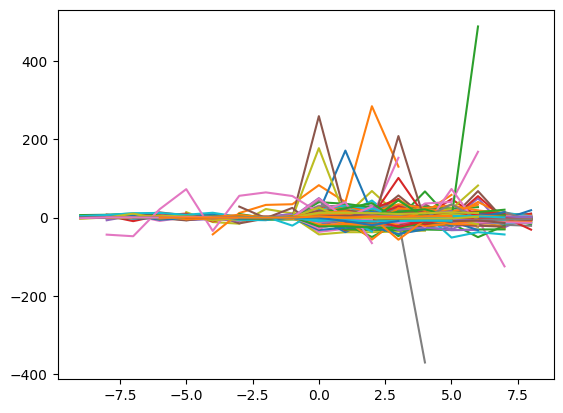

In [91]:
isc_list = isc(samples)

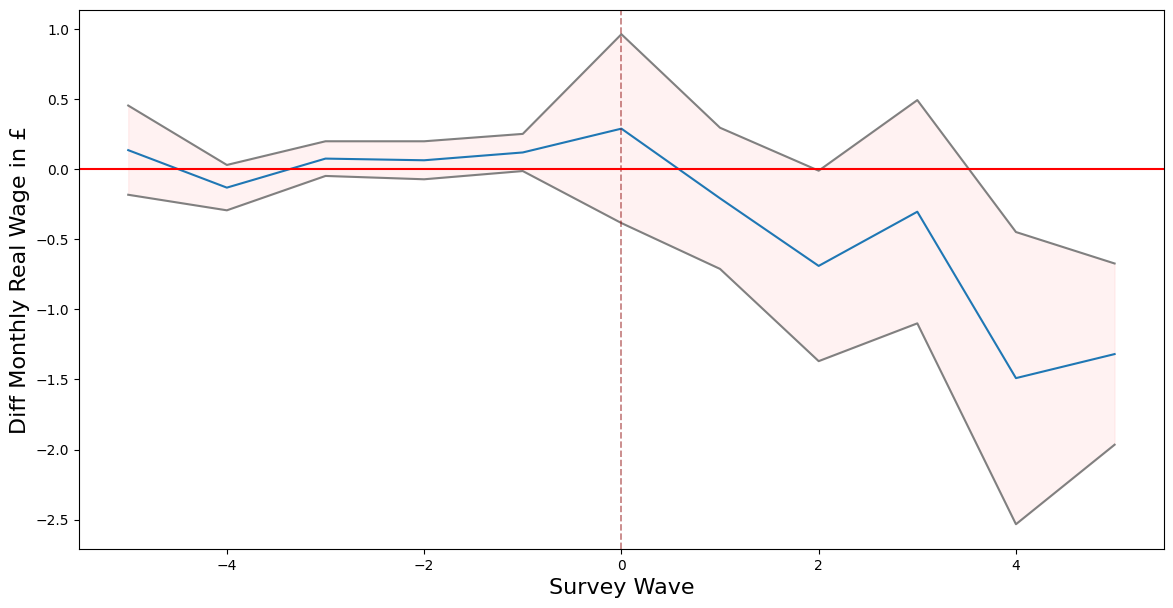

In [93]:
import math
import matplotlib.ticker as mtick
from matplotlib.pyplot import figure

figure(figsize=(14, 7))
differences = pd.concat(isc_list['diffs'], axis=1).sort_index()
differences.loc[-5:5].mean(axis=1).plot()
(differences.loc[-5:5].mean(axis=1) + (1.96*(differences.loc[-5:5].std(axis=1)/differences.loc[-5:5].count(axis=1).apply(math.sqrt)))).plot(color='grey')
(differences.loc[-5:5].mean(axis=1) - (1.96*(differences.loc[-5:5].std(axis=1)/differences.loc[-5:5].count(axis=1).apply(math.sqrt)))).plot(color='grey')
differences.count()
plt.axvline(x=0, linestyle='--', color='darkred', alpha=.5, linewidth=1.25)
plt.xlabel('Survey Wave', fontsize=16)
plt.ylabel('Diff Monthly Real Wage in £', fontsize=16)
plt.axhline(y=0, color='r', linestyle='-')
plt.fill_between(x=differences.loc[-5:5].index,
                 y1=differences.loc[-5:5].mean(axis=1) + (1.96*(differences.loc[-5:5].std(axis=1)/differences.loc[-5:5].count(axis=1).apply(math.sqrt))),
                 y2=differences.loc[-5:5].mean(axis=1) - (1.96*(differences.loc[-5:5].std(axis=1)/differences.loc[-5:5].count(axis=1).apply(math.sqrt))),
                     color='red', alpha=0.05)
plt.show()

In [84]:
differences.count(axis=1)

-9     24
-8     67
-7    121
-6    203
-5    332
-4    509
-3    715
-2    715
-1    715
 0    715
 1    715
 2    715
 3    628
 4    541
 5    437
 6    339
 7    189
 8     83
dtype: int64

In [85]:
def select_consecutive(series, value, consecutive_count):
    # Convert series to a list
    data = list(series)
    
    # Initialize counters
    count = 0
    
    # Iterate through the list
    for i in range(len(data)):
        if data[i] == value:
            count += 1
            print(count)
            if count == consecutive_count:
                return True
                break
        else:
            count = 0
    return False


In [86]:
# Example usage
my_series = pd.Series([0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1])

select_consecutive(my_series, 1, 5)


1
2
3
1
1
2
3
4


False

In [68]:
l = [6,8, 7,9]



True

In [83]:
def is_consecutive(l):
    return sorted(l) == list(range(min(l), max(l)+1))
idx = []
for pidp in carers.pidp:
    idx.append(is_consecutive(carers[carers.pidp == pidp].wave))

In [87]:
carers[idx]

3    2016
4    1212
5     859
6     521
7     355
8     167
9     132
Name: waves_caring, dtype: int64